# Plot analytics

In [2]:
import contextlib
import json
import math
import os

import matplotlib.pyplot as plt
import scipy
from cycler import cycler

## Utils

In [3]:
LOGS_PATH = "../logs/"

LOGS_DIR: dict[str, str] = {
    "a2c": "a2c",
    "reinforce": "reinforce",
    "dqn": "dqn",
    "cnn1d": "cnn_1d",
    "cnn2d": "cnn_2d",
    "lstm": "lstm",
    "bilstm": "lstm_bi",
    "lstm_attn": "lstm_attn",
    "bilstm_attn": "lstm_bi_attn",
}

RLS = [
    "a2c",
    "reinforce",
    "dqn",
]

BASELINES = [
    "cnn1d",
    "cnn2d",
    "lstm",
    "bilstm",
    "lstm_attn",
    "bilstm_attn",
]

In [4]:
def load_json(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)


def get_max_index(path: str) -> int:
    max_index = 0
    for file in os.listdir(path):
        with contextlib.suppress(ValueError):
            max_index = max(max_index, int(os.path.splitext(file)[0]))
    return max_index

In [5]:
def moving_average(x, w=10):
    w = min(w, max(1, len(x) // 10))
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))

In [6]:
def get_dict_differences(dicts: list[dict]) -> list[dict]:
    if len(dicts) == 0:
        return []
    common_values = set(dicts[0].items())
    for d in dicts:
        common_values = common_values & set(d.items())

    return [dict(set(d.items()) - common_values) for d in dicts]

In [7]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


def draw_plots(
    data_dict: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 8,
    plot_height: float = 4,
    use_rainbow: bool = False,
    use_common_legend: bool = True,
    adjust: bool = False,
):
    num_plots = len(plots)
    num_entities = len(data_dict)
    if use_rainbow:
        num_colors = num_entities
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )

    if len(title) > 0:
        fig.suptitle(title, fontsize=14, y=1)
    axs_list = [axs] if column_plots * row_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)
        ax.set_visible(False)

    for ax, (p1, p2) in zip(axs_list, plots):
        ax.set_visible(True)

        ax.set_title(f"{p2['axis_name']} over {p1['axis_name']}")
        ax.set(xlabel=p1["axis_label"], ylabel=p2["axis_label"])

        if p1.get("log", False):
            ax.set_xscale("log")
        if p2.get("log", False):
            ax.set_yscale("log")

        longest_x_values = []
        for entity_name, entity_dict in data_dict.items():
            x_values = entity_dict[p1.get("ref", None) or p1["axis_name"]]
            if len(x_values) > len(longest_x_values):
                longest_x_values = x_values
            y_values = entity_dict[p2.get("ref", None) or p2["axis_name"]]

            average_w = p2.get("averaged", None)
            if average_w:
                y_values = moving_average(y_values, average_w)
            ax.plot(x_values, y_values, label=entity_name)
            ax.scatter(x_values[-1], y_values[-1], s=15)

        p2vs = p2.get("values", [])
        for p2v in p2vs:
            y_values = data_dict[p2v.get("ref", None) or p2v["name"]]
            try:
                iter(y_values)
                ax.plot(x_values, y_values, label=p2v["name"])
                ax.scatter(x_values[-1], y_values[-1], s=15)
            except TypeError:
                ax.plot(x_values, [y_values] * len(x_values), label=p2v["name"])

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(6, num_entities),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if num_entities > 1:
            for ax, _ in zip(axs_list, plots):
                ax.legend()

    plt.tight_layout()
    if adjust:
        plt.subplots_adjust(
            top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
        )

    plt.show()
    return fig

## Baseline utils

In [8]:
def choose_best_baseline_experiment(baseline_name: str) -> str:
    baseline_log_path = os.path.join(LOGS_PATH, LOGS_DIR[baseline_name])

    best_experiment = ""
    best_loss = 2

    for experiment_dir in os.listdir(baseline_log_path):
        with contextlib.suppress(Exception):
            best_dict = load_json(
                os.path.join(baseline_log_path, experiment_dir, "best.json")
            )
            experiment_loss = next(iter(best_dict.values()))
            if experiment_loss < best_loss:
                best_experiment = experiment_dir
                best_loss = experiment_loss

    return f"{baseline_log_path}/{best_experiment}"


def get_baseline_experiment(experiment_path: str) -> tuple[dict, tuple[int, float]]:
    last_idx = get_max_index(experiment_path)

    data_dict = load_json(
        os.path.join(experiment_path, str(last_idx), "data/log_data.json")
    )
    best_dict = load_json(os.path.join(experiment_path, "best.json"))

    epoch, loss = next(iter(best_dict.items()))

    return data_dict, (int(epoch), loss)

In [9]:
def draw_baseline_plots(data_dict: dict, **kwargs):
    plot_epoch_axis = {"axis_name": "Epoch", "axis_label": "Epoch"}
    plot_time_axis = {"axis_name": "Time", "axis_label": "Running time, seconds"}
    log_plots = [
        (
            plot_epoch_axis,
            {"axis_name": "Mean Loss", "axis_label": "Loss", "averaged": 100},
        ),
        (
            plot_time_axis,
            {"axis_name": "Mean Loss", "axis_label": "Loss", "averaged": 100},
        ),
        (
            {**plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
        (
            {**plot_time_axis, "ref": "Eval Time"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
    ]

    draw_plots(data_dict, log_plots, row_plots=2, **kwargs)

## RL Utils

In [10]:
def get_rl_bests(
    rl_name: str, include: set[str] = set(), exclude: set[str] = set()
) -> list[tuple]:
    experiments_path = os.path.join(LOGS_PATH, LOGS_DIR[rl_name])

    best_experiments_dict = {}  # del_ratio :(experiment, loss, epoch)

    experiments = os.listdir(experiments_path) if len(include) == 0 else include

    for experiment_dir in experiments:
        if experiment_dir in exclude:
            continue
        with contextlib.suppress(Exception):
            best_dict = load_json(
                os.path.join(experiments_path, experiment_dir, "best.json")
            )
            for deletions_ratio, (loss, epoch) in best_dict.items():
                deletions_ratio = float(deletions_ratio)
                check_ls = [
                    ls
                    for d, (_, ls, __) in best_experiments_dict.items()
                    if d >= deletions_ratio
                ]
                # check if we removed more and got less loss
                if len(check_ls) > 0 and loss >= min(check_ls):
                    continue

                # remove when we deleted less and got bigger loss
                to_delete = [
                    d
                    for d, (_, ls, __) in best_experiments_dict.items()
                    if d <= deletions_ratio and ls >= loss
                ]
                for del_k in to_delete:
                    del best_experiments_dict[del_k]

                best_experiments_dict[deletions_ratio] = (experiment_dir, loss, epoch)

    return sorted(
        [(n, ls, d, e) for d, (n, ls, e) in best_experiments_dict.items()],
        key=lambda x: x[1],
    )


def get_rl_experiments(
    rl_name: str, include: set[str] = set(), exclude: set[str] = set()
) -> dict:
    experiments_path = os.path.join(LOGS_PATH, LOGS_DIR[rl_name])

    experiments = os.listdir(experiments_path) if len(include) == 0 else include

    experiments_dict = {}

    for experiment_dir in experiments:
        if experiment_dir in exclude:
            continue
        experiment_path = os.path.join(experiments_path, experiment_dir)

        max_idx = str(get_max_index(experiment_path))

        experiments_dict[experiment_dir] = load_json(
            os.path.join(experiment_path, max_idx, "data/log_data.json")
        )

        experiments_dict[experiment_dir].update(
            load_json(os.path.join(experiment_path, max_idx, "data/statistics.json"))
        )
    return experiments_dict


def experiments_configs_difference(
    rl_name: str, include: set[str] = set(), exclude: set[str] = set()
) -> list[tuple[str, dict]]:
    experiments_path = os.path.join(LOGS_PATH, LOGS_DIR[rl_name])

    experiments = os.listdir(experiments_path) if len(include) == 0 else include

    configs = []

    experiment_names = []

    for experiment_dir in experiments:
        if experiment_dir in exclude:
            continue
        experiment_path = os.path.join(experiments_path, experiment_dir)

        configs.append(load_json(os.path.join(experiment_path, "configs.json")))
        experiment_names.append(experiment_dir)

    return list(zip(experiment_names, get_dict_differences(configs)))

In [11]:
def draw_rl_experiments_plots(data_dict: dict, **kwargs):
    plot_epoch_axis = {"axis_name": "Epoch", "axis_label": "Epoch"}
    plot_time_axis = {"axis_name": "Time", "axis_label": "Running time, seconds"}
    log_plots = [
        (
            plot_epoch_axis,
            {"axis_name": "Mean RNet Loss", "axis_label": "Loss", "averaged": 100},
        ),
        (
            plot_time_axis,
            {"axis_name": "Mean RNet Loss", "axis_label": "Loss", "averaged": 100},
        ),
        (
            {**plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
        (
            {**plot_time_axis, "ref": "Eval Time"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
        (
            {**plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Test Deletions ratio", "axis_label": "deleted / total"},
        ),
    ]

    draw_plots(data_dict, log_plots, row_plots=2, **kwargs)

In [12]:
def show_full_rl_info(
    rl_algo: str,
    beat_loss: float = 2,
    include: set[str] = set(),
    exclude: set[str] = set(),
):
    # print(f"{'EXPERIMENT':<12} | {'LOSS':<20} | {'DEL RATIO':<20} | {'EPOCH':<10}")
    print(f"{'LOSS':<20} | {'DEL RATIO':<20} | {'EPOCH':<10}")
    for name, loss, del_ratio, epoch in get_rl_bests(rl_algo, include, exclude):
        if loss < beat_loss:
            # print(f"{name:<12} | {loss:<20} | {del_ratio:<20} | {epoch:<10}")
            print(f"{loss:<20} | {del_ratio:<20} | {epoch:<10}")

    draw_rl_experiments_plots(
        get_rl_experiments(rl_algo, include, exclude), title=rl_algo.upper()
    )

    for experiment, diff_configs in experiments_configs_difference(
        rl_algo, include, exclude
    ):
        print(experiment)
        configs_str = "\t"
        for key, value in sorted(diff_configs.items(), key=lambda x: x[0]):
            configs_str = f"{configs_str}{key}: {value:<5}, "
        print(configs_str)

## Baselines

In [13]:
baseline_logs = {}
best_baseline_loss = {}

print(f"{'BASELINE':<12} | {'LOSS':<20} | {'EPOCH':<10}")
for baseline in BASELINES:
    logs, (best_epoch, best_loss) = get_baseline_experiment(
        choose_best_baseline_experiment(baseline)
    )
    baseline_logs[baseline] = logs
    best_baseline_loss[baseline] = best_loss
    print(f"{baseline:<12} | {best_loss:<20} | {best_epoch:<10}")

BASELINE     | LOSS                 | EPOCH     
cnn1d        | 0.1443049750290811   | 680       
cnn2d        | 0.13314360574198267  | 1110      
lstm         | 0.1604354648035951   | 5320      
bilstm       | 0.1601444248110056   | 80        
lstm_attn    | 0.16581105250710002  | 10        
bilstm_attn  | 0.167869355166719    | 70        


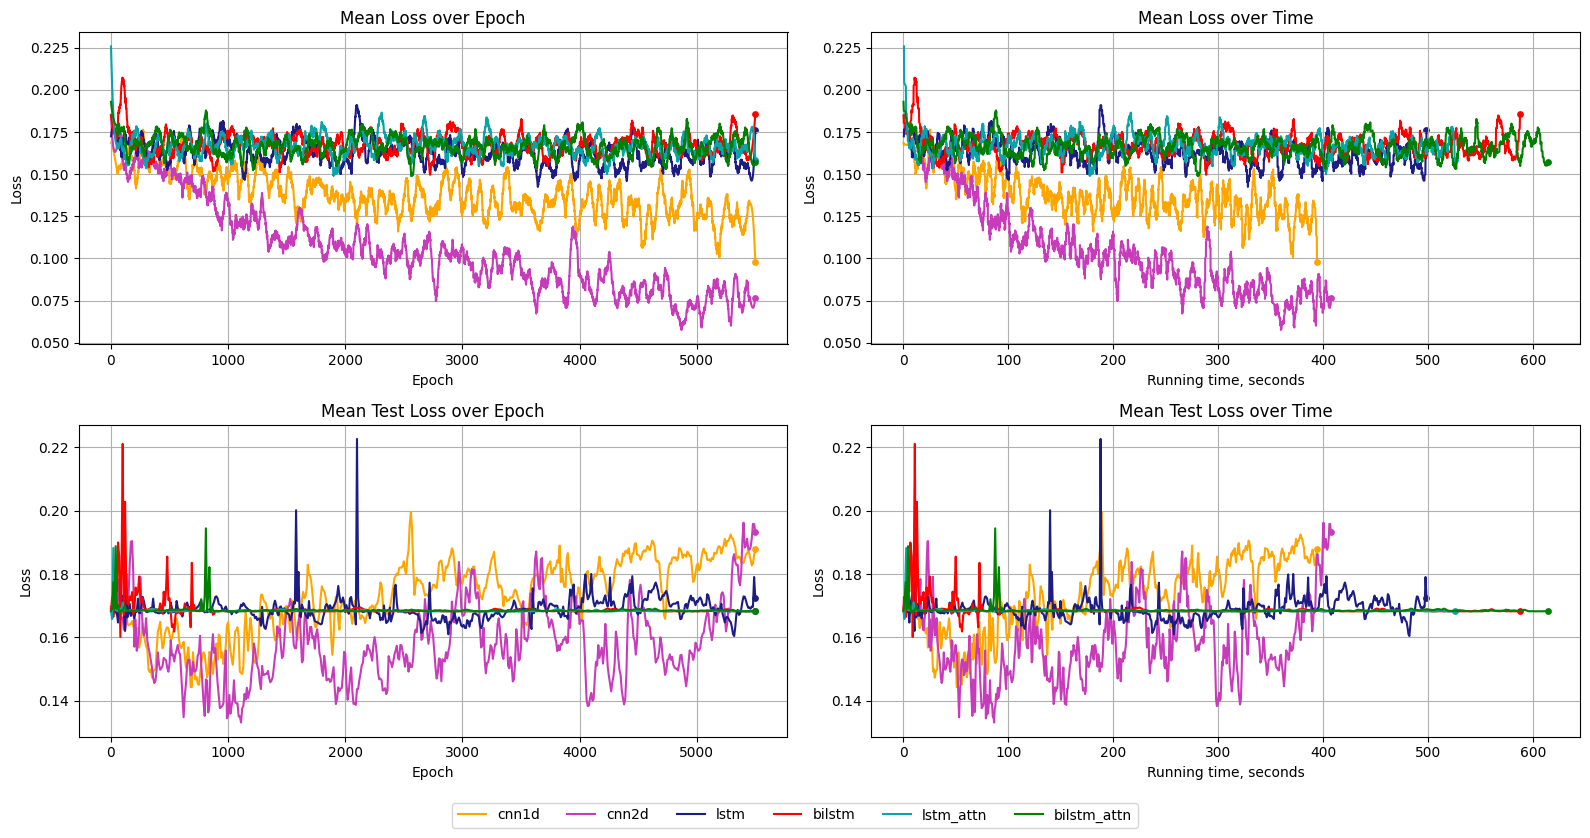

In [14]:
draw_baseline_plots(baseline_logs)

In [15]:
best_baseline_loss = min(best_baseline_loss.values())
best_baseline_loss

0.13314360574198267

## RL

LOSS                 | DEL RATIO            | EPOCH     
0.11875798790437589  | 0.6822536626979951   | 1410      
0.11895933008641267  | 0.8369748991254591   | 1500      
0.12479750412044299  | 0.8867226477761655   | 1320      
0.12699673681419546  | 0.8872727975181717   | 1310      
0.12988950692449927  | 0.9199998148366338   | 1190      
0.13240317481120123  | 0.936849878459488    | 1150      


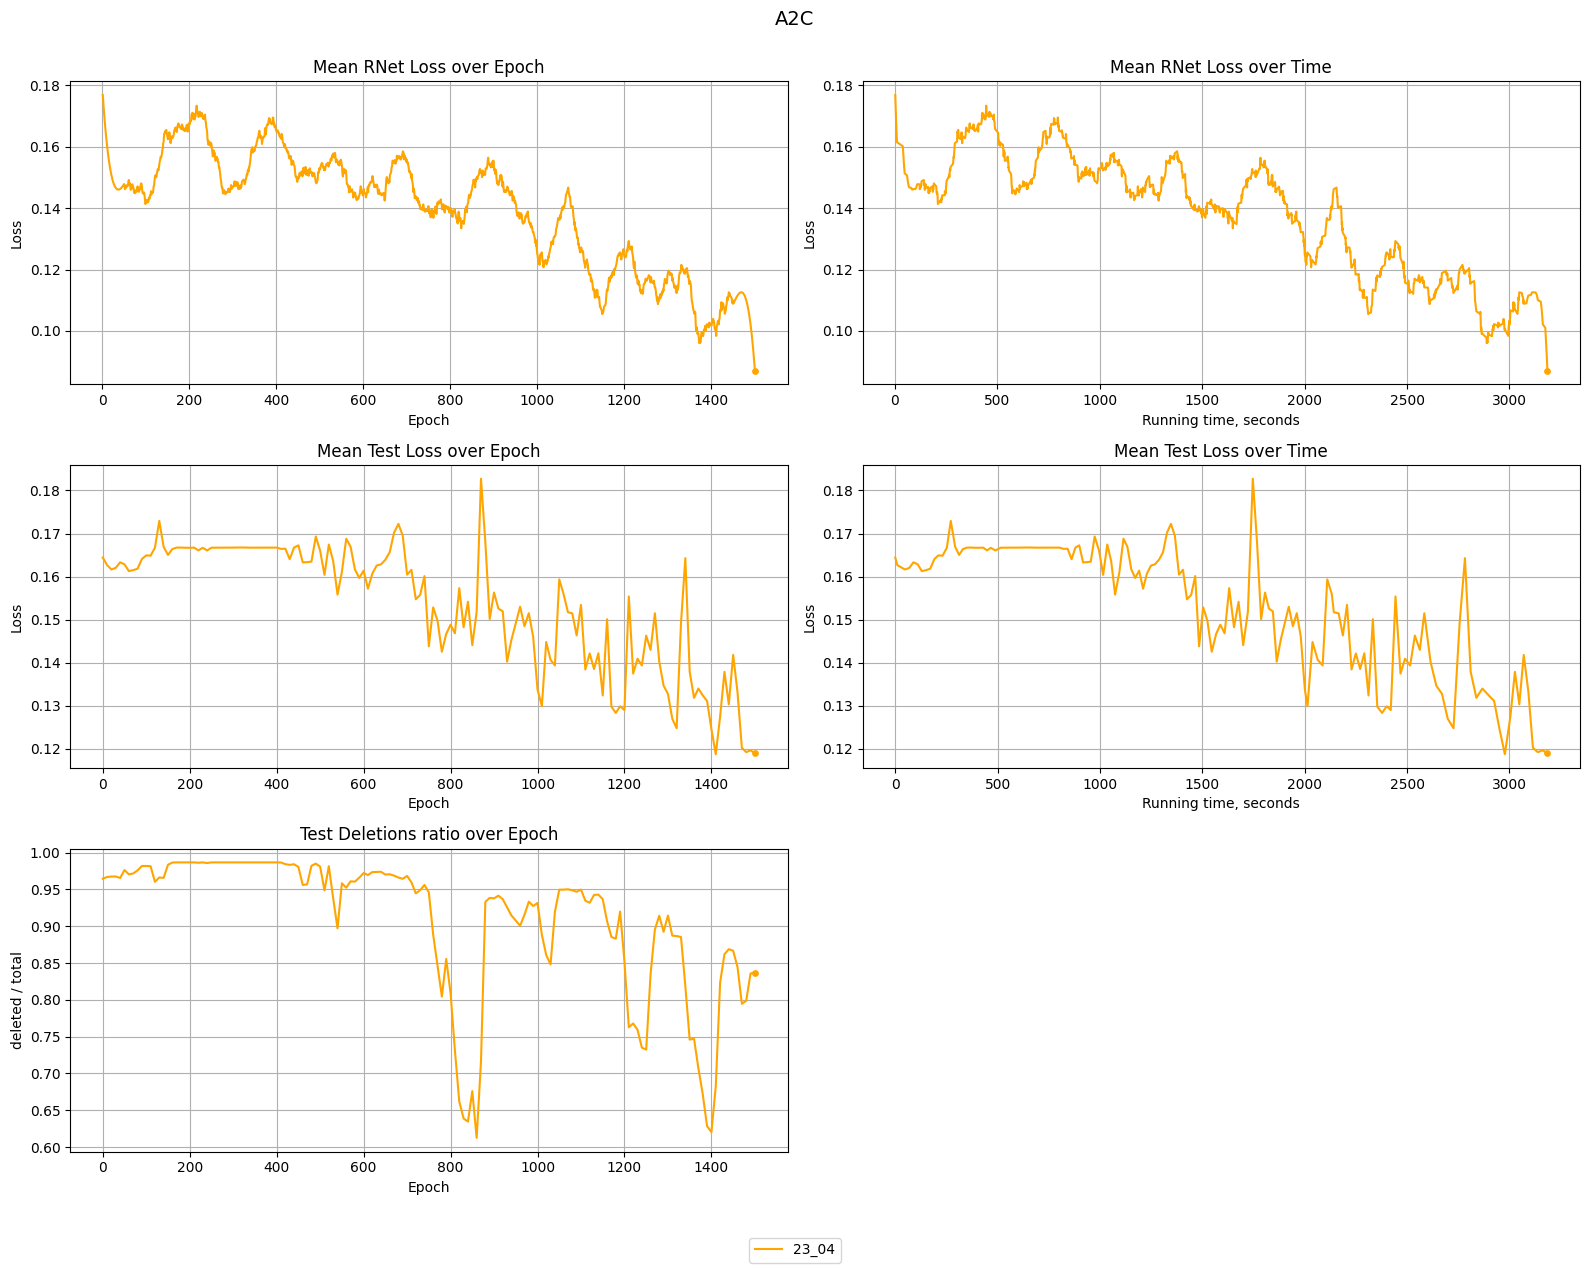

23_04
	


In [16]:
show_full_rl_info("a2c", beat_loss=best_baseline_loss)

LOSS                 | DEL RATIO            | EPOCH     
0.09694839975112472  | 0.026327840347923386 | 1330      
0.10235290513292222  | 0.05435900375419396  | 1230      
0.10318301459735185  | 0.10163843841872539  | 1090      
0.10695926911291286  | 0.19916076799050703  | 1150      
0.10821691707223896  | 0.3419966980143809   | 1400      


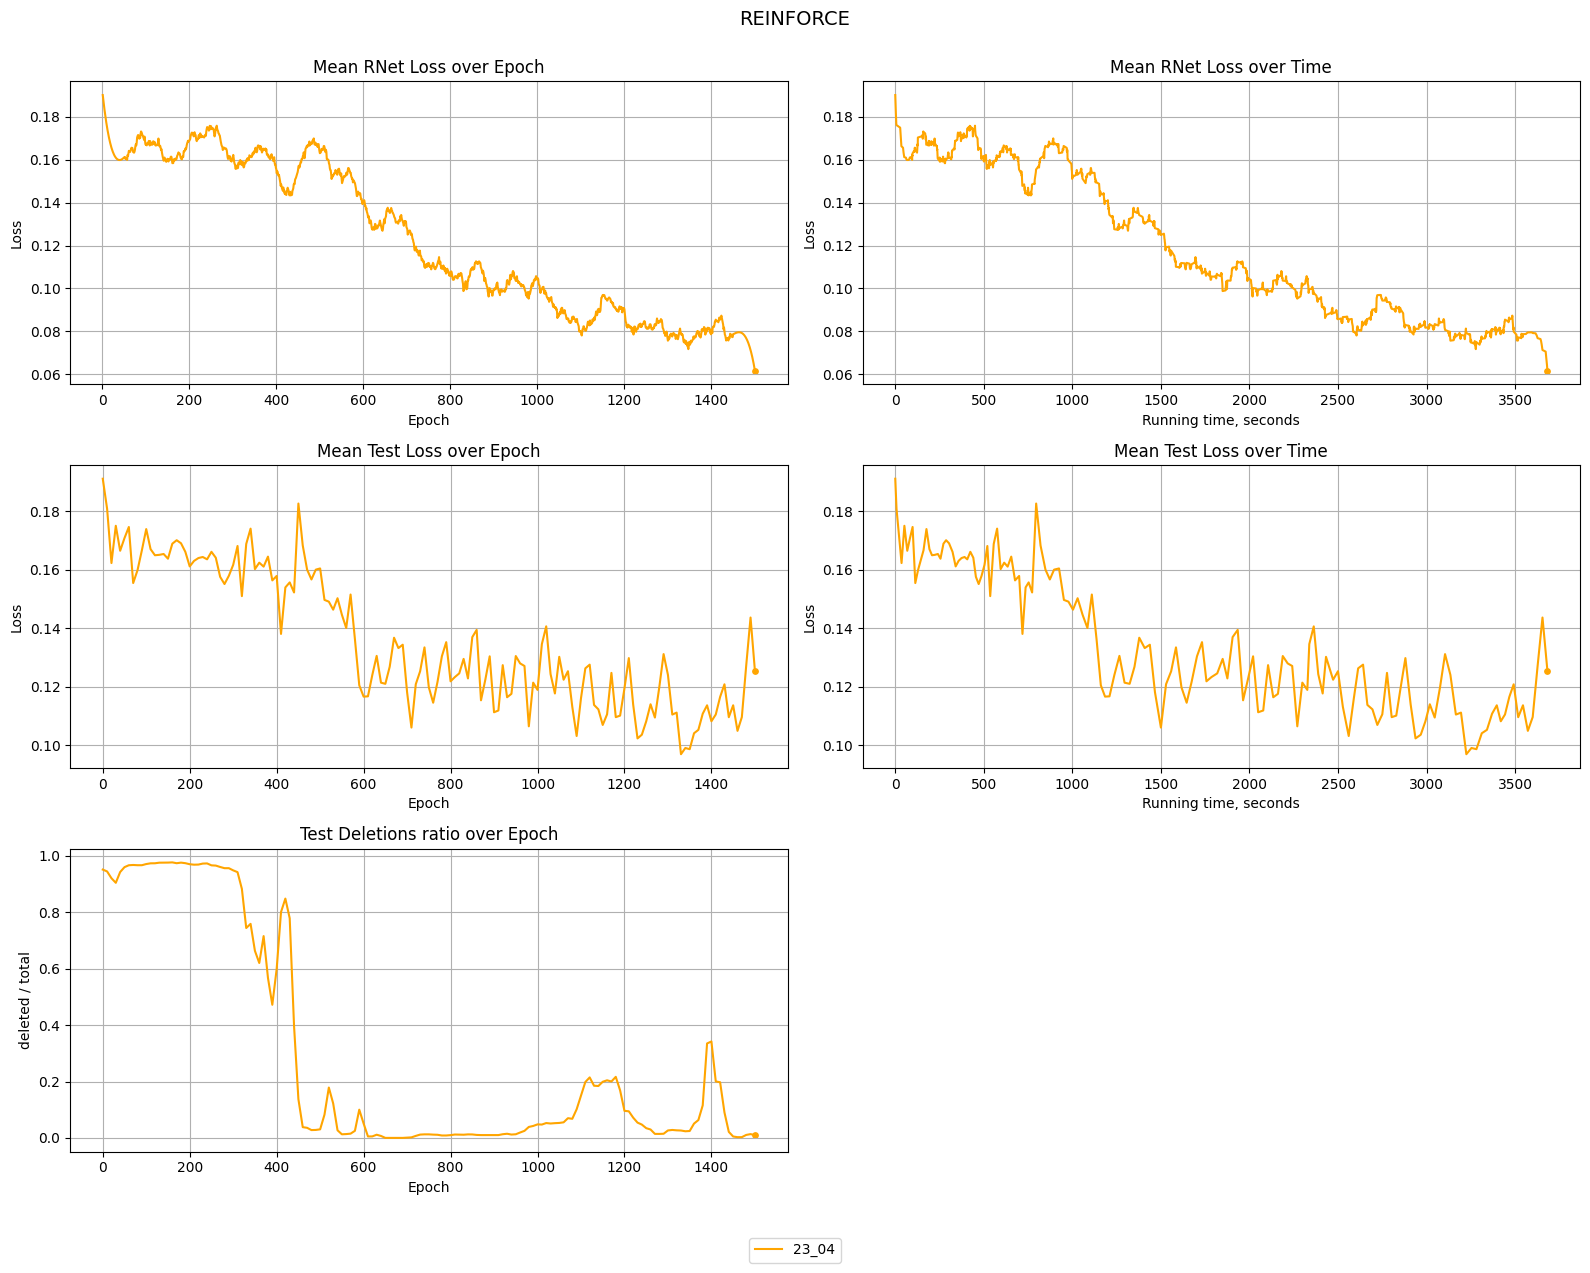

23_04
	


In [17]:
show_full_rl_info("reinforce", beat_loss=best_baseline_loss)

LOSS                 | DEL RATIO            | EPOCH     
0.11191013485284546  | 0.0033352342673597293 | 1420      
0.12661239515114175  | 0.27972646425959413  | 1140      


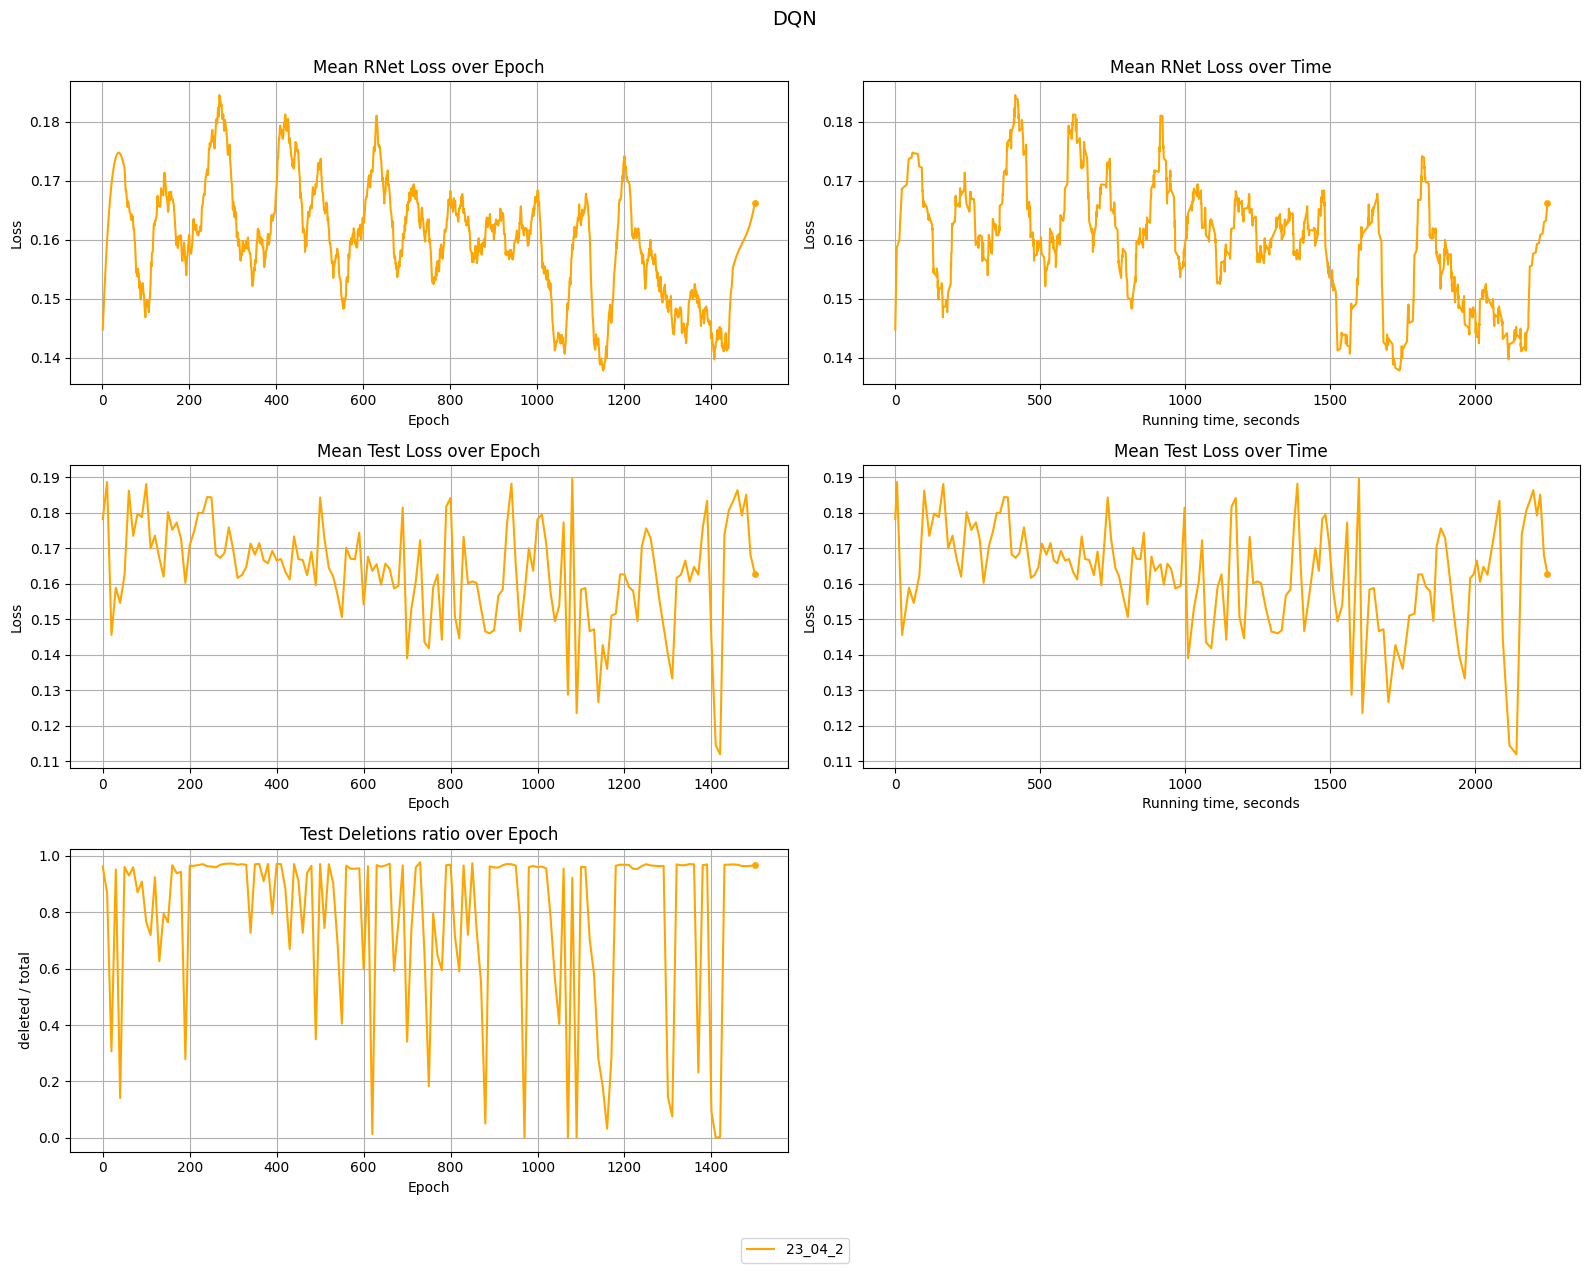

23_04_2
	


In [21]:
show_full_rl_info("dqn", include={"23_04_2"}, beat_loss=best_baseline_loss)
# show_full_rl_info("dqn", include={"23_04_"}, beat_loss=best_baseline_loss)